In [9]:
import pandas as pd
import numpy as np
import import_ipynb
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr
from fastdtw import fastdtw
import random
from Barycenter_DTW import resample_sequence, barycenter_dtw
from Weighted_DTW import weighted_dtw

# random.seed(42)

In [10]:
# Use %store to retrieve the variable
%store -r z_jump_rs
%store -r z_walk_rs
%store -r z_skip_rs
%store -r z_skip
%store -r z_skip_cycles

# candidate 2
%store -r g_jump_rs
%store -r g_walk_rs
%store -r g_skip_rs
%store -r g_skip
%store -r g_skip_cycles

## Shapelet results

In [11]:
# barycenter_dtw
z_barycenter_df = barycenter_dtw(pd.DataFrame(z_walk_rs), pd.concat([pd.DataFrame(z_jump_rs), pd.DataFrame(z_jump_rs)], ignore_index=True))

g_barycenter_df = barycenter_dtw(pd.DataFrame(g_walk_rs), pd.concat([pd.DataFrame(g_jump_rs), pd.DataFrame(g_jump_rs)], ignore_index=True))

# Weighted_dtw
z_weighted_df = weighted_dtw(pd.DataFrame(z_walk_rs), pd.concat([pd.DataFrame(z_jump_rs), pd.DataFrame(z_jump_rs)], ignore_index=True), 0.5, 1)

g_weighted_df = weighted_dtw(pd.DataFrame(g_walk_rs), pd.concat([pd.DataFrame(g_jump_rs), pd.DataFrame(g_jump_rs)], ignore_index=True), 0.5, 1)

In [84]:
%store z_barycenter_df

Stored 'z_barycenter_df' (DataFrame)


## Util methods

In [12]:
def visual_comparison(dist_arr1, dist_arr2, label1, label2, method):
    """
    This is a method to visualize the distance comparison

    :dist_arr1: is an array of distance
    :dist_arr2: is an array of distance
    :label1: is the name of dist_arr1
    :label2: is the name of dist_arr2
    :method: is the name of this comparing method
    """
    # calculate mean, min, max
    for tuple in ((dist_arr1, label1), (dist_arr2, label2)):
        metrics = {'Mean' : [np.mean(tuple[0])], 'Min' : [np.min(tuple[0])], 'Max' : [np.max(tuple[0])]}
        df = pd.DataFrame(metrics)
        # Print the title
        print(tuple[1].center(35, '-'))
        display(df)
    dist_arr1 = sorted(dist_arr1)
    dist_arr2 = sorted(dist_arr2)
    print(dist_arr1)
    print(dist_arr2)
    plt.plot(dist_arr1, label=label1)
    plt.plot(dist_arr2, label=label2)
    plt.xlabel('a window')
    plt.ylabel('distance')
    plt.title('Distance Comparison(' + method + ')')
    plt.legend()
    plt.show()

def significance_test(arr1, arr2):
    # Perform a two-sample t-test
    t_statistic, p_value = stats.ttest_ind(arr1, arr2)
    # Print the results
    print("t-statistic:", t_statistic)
    print("p-value:", p_value)
    # Check if the difference is statistically significant at a 5% significance level
    alpha = 0.05
    if p_value < alpha:
        print("There is a significant difference between the groups.")
    else:
        print("There is no significant difference between the groups.")

def correlation(shapelet1, shapelet2):
    """
    This is a method to calculate correlation efficient(require two shapelets in same)

    :shapelet1: is an array with shapelet value
    :shapelet2: is an array with shapelet value
    """
    if len(shapelet1) != len(shapelet2):
        # if two shapelets length are different, resample the value
        max_length = max(len(shapelet1), len(shapelet2))
        shapelet1_resampled = pd.DataFrame({col: resample_sequence(shapelet1[col].values, max_length) for col in shapelet1.columns})
        shapelet2_resampled = pd.DataFrame({col: resample_sequence(shapelet2[col].values, max_length) for col in shapelet2.columns})
    shapelet1 = shapelet1_resampled.to_numpy()
    shapelet2 = shapelet2_resampled.to_numpy()
    pearson_corr, _ = pearsonr(shapelet1.flatten(), shapelet2.flatten())
    print("Pearson correlation coefficient:", pearson_corr)
    spearman_corr, _ = spearmanr(shapelet1.flatten(), shapelet2.flatten())
    print("Spearman correlation coefficient:", spearman_corr)

## Correlation between Maked shapelet and Skip representative shapelet

####
1 indicates a perfect positive correlation,
-1 indicates a perfect negative correlation, and
0 indicates no correlation.
Pearson correlation assumes a linear relationship, while Spearman correlation assesses monotonic relationships.


In [13]:
# Barycenter-Skip correlation
correlation(z_barycenter_df, pd.DataFrame(z_skip_rs))

Pearson correlation coefficient: 0.7416145610945734
Spearman correlation coefficient: 0.7551816488122963


In [14]:
# Weighted-Skip correlation
correlation(z_weighted_df, pd.DataFrame(z_skip_rs))

Pearson correlation coefficient: 0.742663668551419
Spearman correlation coefficient: 0.7729223501230954


## Evaluate the accuracy by sliding window

In [15]:
def shapelet_window_distance(shapelet, time_series):
    """
    This is a method to calculate the distances by sliding window, window size is shapelet size

    :shapelet: is a dataframe
    :timeseries: is panda.series with activity time series data
    """
    window_size = len(shapelet)
    distances = []
    for i in range(len(time_series) - window_size + 1):
        window = time_series[i : i + window_size]
        window_df = pd.DataFrame(window)
        # Calculate DTW distance between the window and the shapelet
        distance, _ = fastdtw(window_df, shapelet, dist=euclidean)
        distances.append(distance)
    # Plot the original time series and the shapelet
    plt.figure(figsize=(12, 4))
    plt.plot(time_series, label="Time Series")
    plt.plot(np.arange(window_size) + np.argmax(distances), shapelet, label="Max_distance_Shapelet", linestyle="--")
    plt.plot(np.arange(window_size) + np.argmin(distances), shapelet, label="Min_distance_Shapelet", linestyle="--")
    plt.title("Sliding Window DTW Distance with Shapelet")
    plt.legend()
    plt.show()
    return distances

### Candidate 1

#### Barycenter

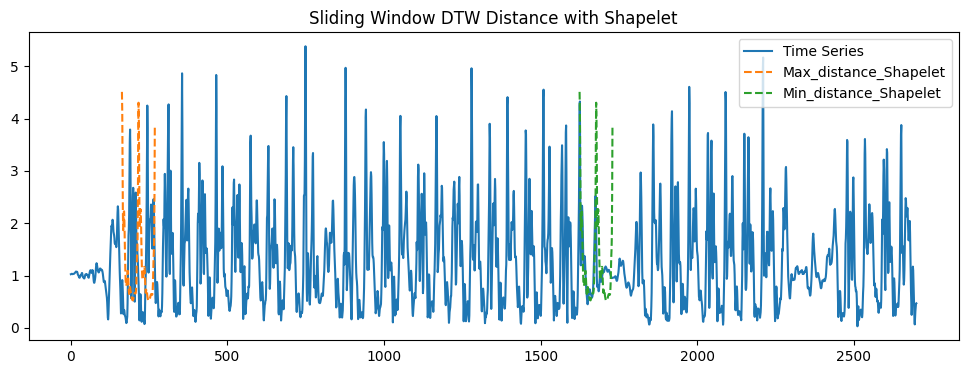

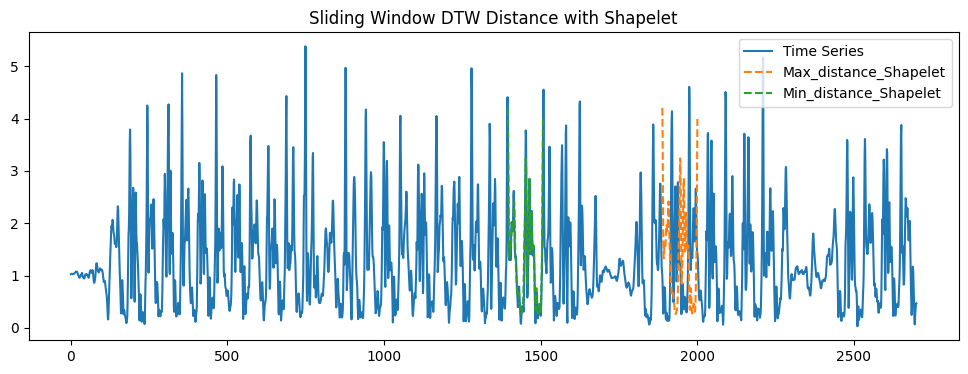

In [16]:
# window_size is shapelet length
z_bc_distances = shapelet_window_distance(z_barycenter_df, z_skip)
# skip_rs
z_rs_distances = shapelet_window_distance(pd.DataFrame(z_skip_rs), z_skip)

-------------barycenter------------


,Mean,Min,Max
0,51.322257,25.075956,99.396175


--------------skip_rs--------------


,Mean,Min,Max
0,48.675704,12.684421,95.746421


[25.075955978275914, 25.247395216344252, 25.919156047888844, 26.280305855477607, 27.00315423558323, 27.164777570353174, 27.233166067701465, 27.276179023090837, 27.392842180439573, 27.49679397433447, 27.569891190104958, 27.62571336150581, 27.6564748560902, 27.71414583521982, 27.765034992102212, 27.77728632936224, 27.800747183815, 27.860888913540983, 27.934435460791434, 28.032985460552585, 28.03699123838221, 28.245414457157676, 28.304452355044596, 28.332880931316563, 28.4318056535851, 28.455776955456304, 28.504722990259754, 28.528292926190357, 28.60475634163627, 28.621566910540114, 28.785300886316367, 28.891847341696263, 28.96228235363428, 28.98243688584759, 29.15979507932354, 29.194390148900744, 29.32458471945091, 29.339734545365097, 29.37897638195123, 29.41513534252927, 29.50040555510626, 29.639104990942727, 29.67835240921693, 29.809997750632327, 29.946263536169226, 29.951682959534626, 29.97784639197541, 30.04812396333748, 30.109671855072307, 30.110243457281804, 30.136564724607126, 30.

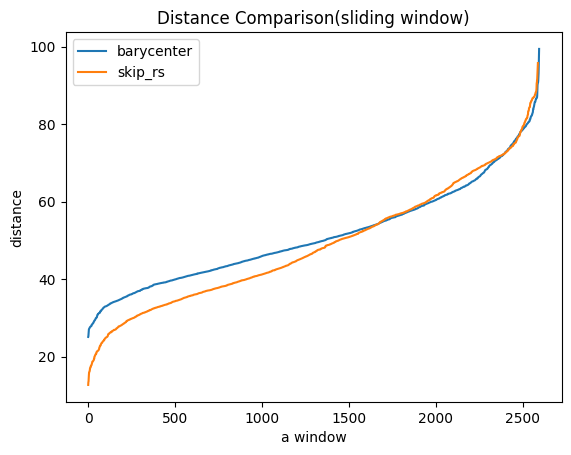

t-statistic: 6.616339416368228
p-value: 4.0534993868873425e-11
There is a significant difference between the groups.


In [17]:
visual_comparison(z_bc_distances, z_rs_distances, label1='barycenter', label2='skip_rs', method='sliding window')
significance_test(z_bc_distances, z_rs_distances)

#### Weighted dtw

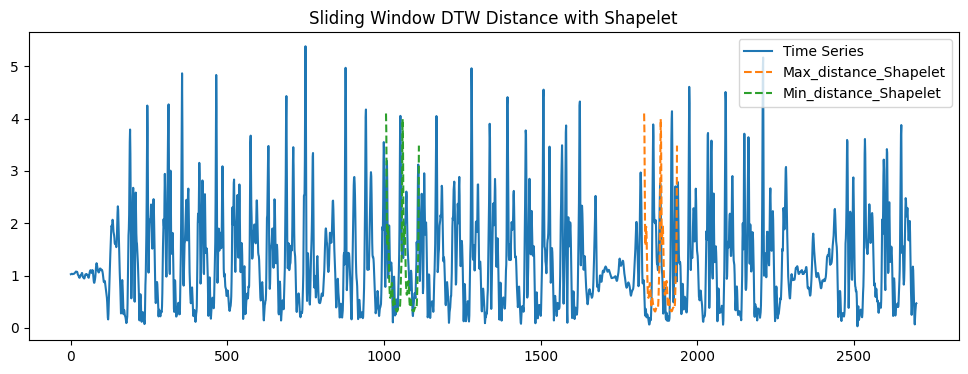

In [18]:
# window_size is shapelet length
z_wt_distances = shapelet_window_distance(z_weighted_df, z_skip)

-------------barycenter------------


,Mean,Min,Max
0,44.414902,20.675235,102.694415


--------------skip_rs--------------


,Mean,Min,Max
0,48.675704,12.684421,95.746421


[20.675234913130286, 21.052840949408694, 21.312072226941332, 21.351086852035873, 22.135474106344716, 22.143072254843364, 22.5150670750011, 22.55390712498221, 22.648462779577333, 22.686507662951342, 22.884925733986826, 22.902131209163702, 22.906628881390766, 22.96860585585209, 22.997882222174706, 23.02315735593926, 23.092951098276586, 23.0948429929489, 23.109021872944275, 23.123536017082973, 23.22060925789875, 23.25070093939969, 23.280739480646286, 23.325185065252544, 23.488484749406137, 23.57953097409775, 23.67277618056723, 23.730189525506976, 23.73182026944756, 23.966569047556618, 24.02414493036162, 24.031060554011603, 24.098326993266355, 24.15759401970576, 24.1879341768569, 24.19793853521734, 24.200241773355035, 24.268749497837433, 24.403891256204954, 24.497944042807013, 24.55428316110161, 24.565762644988364, 24.658479612400722, 24.70860529671283, 24.729147957962326, 24.772486097998318, 24.81139893188447, 24.847020695136568, 24.89488591444936, 24.93265858312295, 24.95391970556991, 25

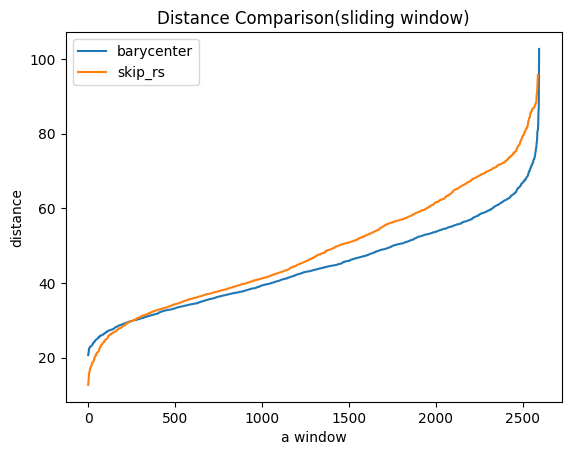

t-statistic: -11.00105890936917
p-value: 7.662078622942432e-28
There is a significant difference between the groups.


In [19]:
visual_comparison(z_wt_distances, z_rs_distances, label1='barycenter', label2='skip_rs', method='sliding window')
significance_test(z_wt_distances, z_rs_distances)

### Candidate 2

#### Barycenter

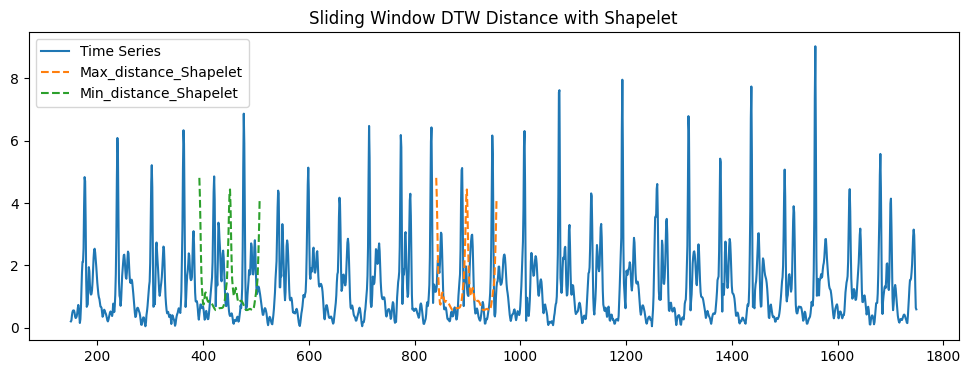

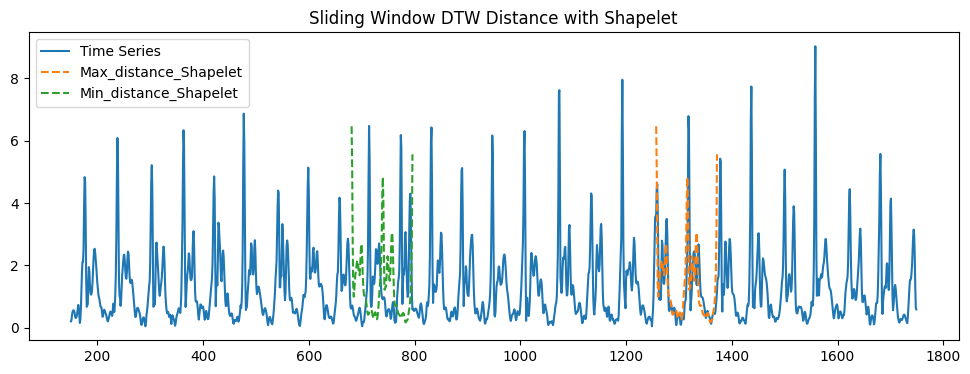

In [20]:
# window_size is shapelet length
g_bc_distances = shapelet_window_distance(g_barycenter_df, g_skip)
# skip_rs
g_rs_distances = shapelet_window_distance(pd.DataFrame(g_skip_rs), g_skip)

-------------barycenter------------


,Mean,Min,Max
0,69.727167,33.631569,104.455679


--------------skip_rs--------------


,Mean,Min,Max
0,56.644634,19.428801,107.288246


[33.63156896512306, 35.24184929394144, 35.912010024719066, 36.35637230603014, 37.355669147589495, 37.59022646626835, 37.621012156835846, 37.84380402177972, 38.164984660313806, 38.32998708603379, 38.70682528267719, 38.967582396179196, 39.204388305095335, 39.40006939134738, 39.451459941416154, 39.64756670172968, 39.78543746555186, 39.792980711995845, 39.85446822142922, 39.92975926221262, 39.968621007244046, 40.094593966838175, 40.0952979594093, 40.183393181793754, 40.36874967601632, 40.61869384151311, 40.82591028858865, 40.972766163565254, 41.21562326795845, 41.67264199962953, 41.69764419140389, 42.034701574158625, 42.22634835468408, 42.30622750255093, 42.336311429010486, 42.3634908252731, 42.44992129408507, 42.482504776276336, 42.54872565388082, 42.671598838651896, 42.68693012075345, 42.873970848871, 42.9049931618456, 43.00772967332854, 43.15579564741576, 43.53517306502267, 43.73507219465001, 43.7703275498783, 44.42983655840382, 44.43790588186425, 44.64099518457451, 44.654844110038326, 

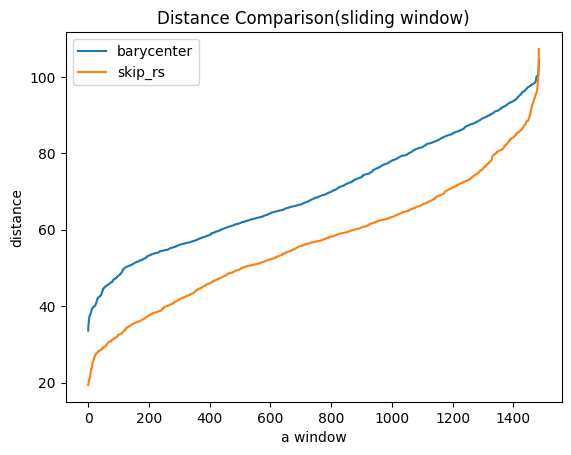

t-statistic: 22.881917782117355
p-value: 7.336994401820924e-107
There is a significant difference between the groups.


In [21]:
visual_comparison(g_bc_distances, g_rs_distances, label1='barycenter', label2='skip_rs', method='sliding window')
significance_test(g_bc_distances, g_rs_distances)

#### Weighted dtw

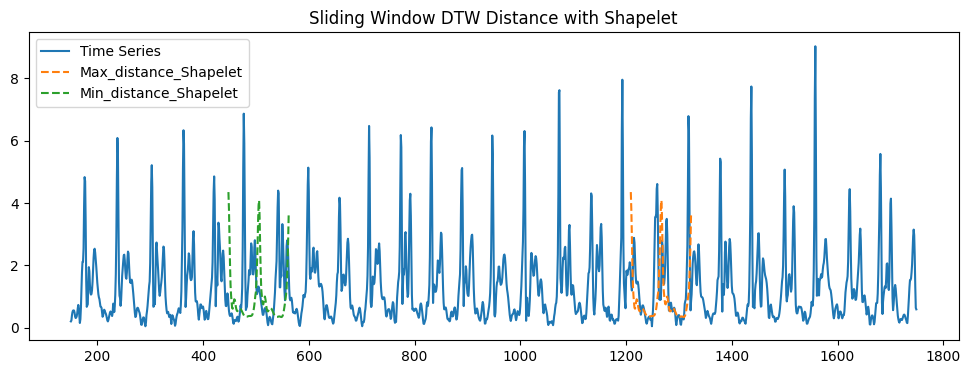

In [22]:
# window_size is shapelet length
g_wt_distances = shapelet_window_distance(g_weighted_df, g_skip)

-------------barycenter------------


,Mean,Min,Max
0,59.862184,26.000436,96.175532


--------------skip_rs--------------


,Mean,Min,Max
0,56.644634,19.428801,107.288246


[26.000436362327903, 26.236669936019098, 27.5348117446786, 27.816847750401394, 28.630109567274193, 29.325542247722588, 29.628421486407557, 30.974532399599205, 31.118305586817222, 31.128789000139683, 31.494133566301006, 31.605429768868532, 32.08379987713794, 32.10078684081217, 32.24597458863839, 32.47680216234187, 32.53407308340758, 32.67844661981436, 33.01272376645934, 33.129670377408544, 33.152560588664755, 33.27003004149993, 33.2898384172339, 33.36564597456747, 33.78221693506333, 33.80654625034858, 34.570556064611274, 34.71195767147395, 34.726909161041526, 34.83396022122543, 34.86778964658798, 34.99538470185907, 35.013212864351196, 35.021312405166775, 35.07462208878688, 35.124091012334496, 35.22276680296163, 35.50803653974502, 35.53511051591147, 35.59074000723198, 35.62534114888865, 35.8516982737388, 35.87827737813148, 36.237619670833205, 36.33228737076352, 36.63718281936049, 36.694364351683106, 36.73498214666341, 36.7593939891341, 36.84205858422268, 36.84254970646195, 36.91301425761

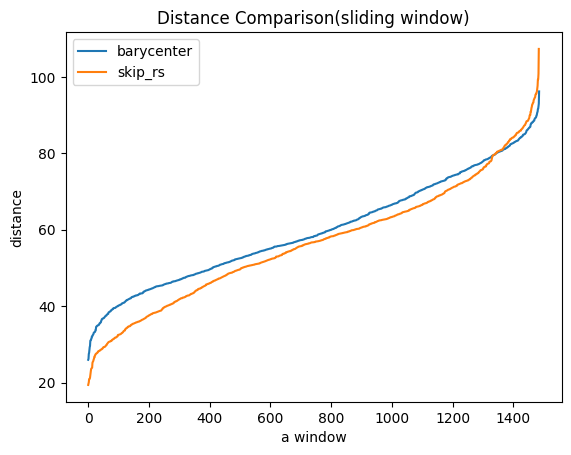

t-statistic: 5.815410574979746
p-value: 6.692516146215574e-09
There is a significant difference between the groups.


In [23]:
visual_comparison(g_wt_distances, g_rs_distances, label1='barycenter', label2='skip_rs', method='sliding window')
significance_test(g_wt_distances, g_rs_distances)

## Evaluate accuracy by cycles in time series

In [24]:
def distances_from_cycle(zqw_skip_cycles, rs_shapelet):
    distances_arr = []
    for arr in zqw_skip_cycles:
        distance, _ = fastdtw(pd.DataFrame(arr), rs_shapelet, dist=euclidean)
        distances_arr.append(distance)
    return distances_arr

### Candidate 1

#### Barycenter

In [25]:
# barycenter
z_bary_dist = distances_from_cycle(z_skip_cycles, z_barycenter_df)
# skip_rs
z_rs_dist = distances_from_cycle(z_skip_cycles, pd.DataFrame(z_skip_rs))

-------------barycenter------------


,Mean,Min,Max
0,39.411953,21.896391,65.332765


--------------skip_rs--------------


,Mean,Min,Max
0,33.027806,14.972689,63.371953


[21.896391272936647, 24.544391493382896, 26.47249096821314, 29.705519380952442, 30.19686421559869, 30.218950479114305, 30.492136397779188, 30.7777109942713, 30.987407509997684, 31.45260445175529, 32.23326875490479, 32.84435086925722, 37.136372211182724, 37.35014382617727, 37.99700583808577, 39.90450903179961, 41.054117106750596, 42.90299601419959, 44.94092879353696, 46.430369995145725, 46.674861433516234, 46.760625980178446, 47.12782111098338, 49.306993101521094, 51.798932274238354, 51.88757465959585, 51.88842583709508, 52.63010919317688, 65.33276515178989]
[14.972689082854908, 15.406352595405679, 15.881692491172682, 15.941661777193485, 17.223280376805846, 17.468086488793546, 19.312786532581917, 19.850688422979147, 21.27572403972739, 22.100018034814013, 25.815984551640696, 26.850290097280585, 28.262841320956873, 30.284557568249397, 31.51906198551802, 34.06364782128957, 34.97996764560495, 36.862567806985076, 37.211651002459114, 38.83887959012655, 40.59747084992821, 41.102180871794175, 4

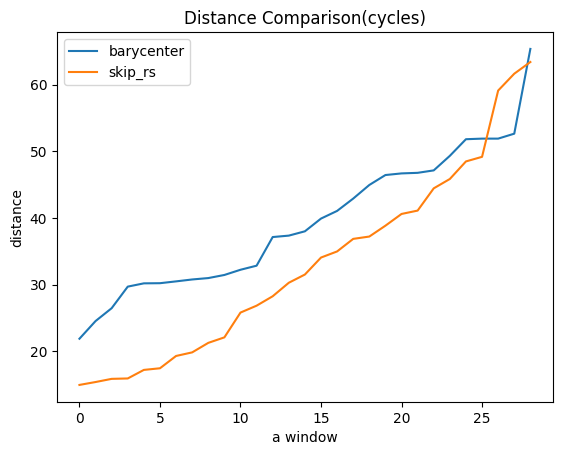

t-statistic: 1.9300916008489963
p-value: 0.05866611193776723
There is no significant difference between the groups.


In [26]:
visual_comparison(z_bary_dist, z_rs_dist, label1='barycenter', label2='skip_rs', method='cycles' )
significance_test(z_bary_dist, z_rs_dist)

#### Weighted dtw

-------------barycenter------------


,Mean,Min,Max
0,36.944655,17.993005,87.485957


--------------skip_rs--------------


,Mean,Min,Max
0,33.027806,14.972689,63.371953


[17.99300491286795, 21.89793430456603, 23.04295898597746, 24.49129726802838, 25.85458075032067, 26.0387132832224, 26.06968208877408, 28.62707651039811, 28.974824695027788, 31.143184512474644, 32.90586433557454, 35.19870828946007, 36.09359303195235, 36.208126444680374, 36.26464751947551, 38.21877307234139, 38.74377677861278, 39.22667442348537, 39.95164188871992, 40.54610303959053, 40.98282343794519, 41.15732446618815, 42.90535294338675, 42.906171577781045, 43.348299827594424, 44.66080530405223, 45.34066816459796, 55.1164133812679, 87.48595664823819]
[14.972689082854908, 15.406352595405679, 15.881692491172682, 15.941661777193485, 17.223280376805846, 17.468086488793546, 19.312786532581917, 19.850688422979147, 21.27572403972739, 22.100018034814013, 25.815984551640696, 26.850290097280585, 28.262841320956873, 30.284557568249397, 31.51906198551802, 34.06364782128957, 34.97996764560495, 36.862567806985076, 37.211651002459114, 38.83887959012655, 40.59747084992821, 41.102180871794175, 44.4362928

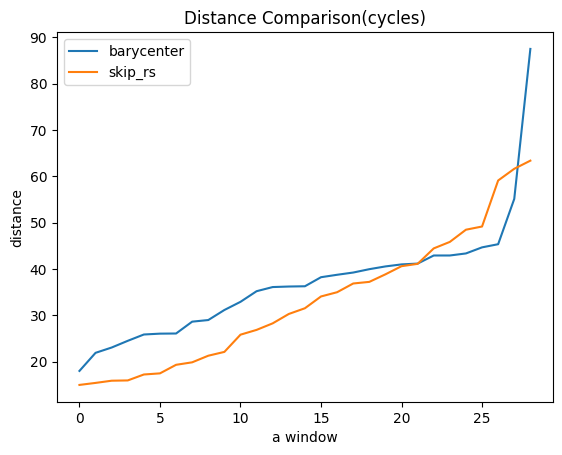

t-statistic: 1.0874501046812801
p-value: 0.28149631808736697
There is no significant difference between the groups.


In [27]:
z_weighted_dist = distances_from_cycle(z_skip_cycles, z_weighted_df)
visual_comparison(z_weighted_dist, z_rs_dist, label1='barycenter', label2='skip_rs', method='cycles' )
significance_test(z_weighted_dist, z_rs_dist)

### Candidate 2

#### Barycenter

In [28]:
# barycenter
g_bary_dist = distances_from_cycle(g_skip_cycles, g_barycenter_df)
# skip_rs
g_rs_dist = distances_from_cycle(g_skip_cycles, pd.DataFrame(g_skip_rs))

-------------barycenter------------


,Mean,Min,Max
0,50.725114,27.084183,66.0174


--------------skip_rs--------------


,Mean,Min,Max
0,42.372542,20.139492,59.80756


[27.084182800244793, 32.841044757305205, 37.451870181086754, 37.59676302892139, 41.34792810111842, 44.05010361289178, 44.95352541615626, 48.14306728547142, 50.86988935113042, 53.26083660451924, 54.10850776980459, 54.85382303018592, 55.190293504133216, 55.572548955583656, 58.147181875608425, 61.44751572474283, 62.077908719447485, 63.57933214428033, 65.90856362998797, 66.01739999497799]
[20.139492092635265, 21.03259198303612, 21.580635899361937, 22.942089200086947, 26.52053995930066, 35.35438608191015, 36.489507497115355, 39.836520262427705, 41.551100612129055, 42.13373329170397, 44.25010109922335, 48.71599073266802, 51.35073354004174, 52.315853637623526, 53.77179168016428, 56.3922103533128, 56.54644842917957, 57.034188041651255, 59.68536804727942, 59.80756002977078]


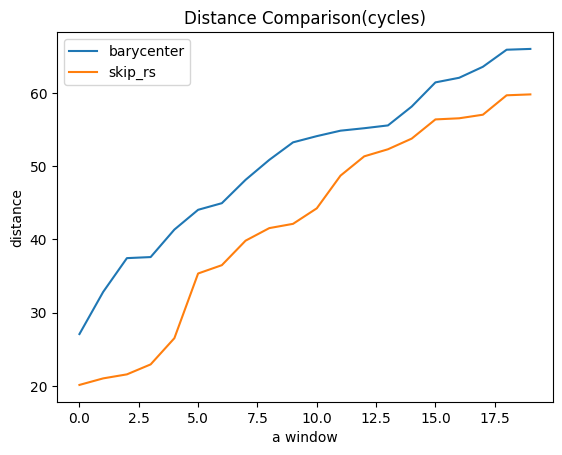

t-statistic: 2.0885120967792457
p-value: 0.04350400440268202
There is a significant difference between the groups.


In [29]:
visual_comparison(g_bary_dist, g_rs_dist, label1='barycenter', label2='skip_rs', method='cycles' )
significance_test(g_bary_dist, g_rs_dist)

#### Weighted dtw

-------------barycenter------------


,Mean,Min,Max
0,47.576944,29.023864,56.982712


--------------skip_rs--------------


,Mean,Min,Max
0,42.372542,20.139492,59.80756


[29.023864433438458, 41.2967590064009, 42.01574025310089, 42.20118892695015, 42.83457934018084, 44.09478214723438, 45.73844423794924, 46.49867099250935, 46.55252891352116, 47.81316041236986, 49.477287849194134, 50.653729500684385, 50.760888222816945, 50.81700643348306, 51.025408198001884, 51.32931335039909, 51.745619591367024, 54.154252652996334, 56.522947445930136, 56.98271170426243]
[20.139492092635265, 21.03259198303612, 21.580635899361937, 22.942089200086947, 26.52053995930066, 35.35438608191015, 36.489507497115355, 39.836520262427705, 41.551100612129055, 42.13373329170397, 44.25010109922335, 48.71599073266802, 51.35073354004174, 52.315853637623526, 53.77179168016428, 56.3922103533128, 56.54644842917957, 57.034188041651255, 59.68536804727942, 59.80756002977078]


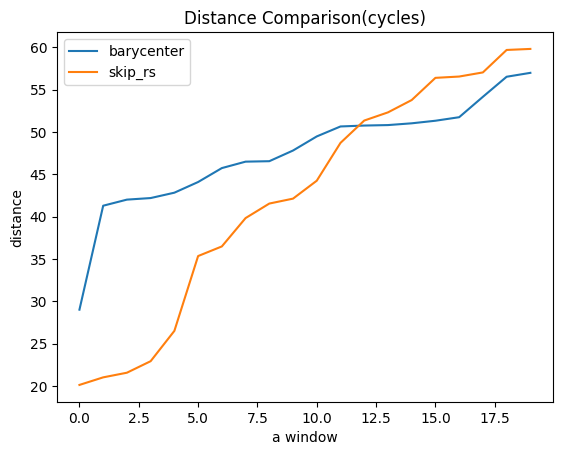

t-statistic: 1.521906789535541
p-value: 0.13631129098338834
There is no significant difference between the groups.


In [30]:
g_weighted_dist = distances_from_cycle(g_skip_cycles, g_weighted_df)
visual_comparison(g_weighted_dist, g_rs_dist, label1='barycenter', label2='skip_rs', method='cycles' )
significance_test(g_weighted_dist, g_rs_dist)

## Evaluate by random pick

In [31]:
def random_compare(shapelet, time_series):
    window_size = len(shapelet)
    data_point = len(time_series)
    distances = []
    count_pick = 1000
    while (count_pick > 0):
        random_int = random.randint(0, data_point - window_size) # avoid out of time series range
        window = time_series[random_int : random_int + window_size]
        window_df = pd.DataFrame(window)
        # Calculate DTW distance between the window and the shapelet
        distance, _ = fastdtw(window_df, pd.DataFrame(shapelet), dist=euclidean)
        distances.append(distance)
        count_pick -= 1
    return distances

### Candidate 1

-------------barycenter------------


,Mean,Min,Max
0,51.321321,25.075956,99.396175


--------------skip_rs--------------


,Mean,Min,Max
0,48.498985,13.42717,88.391113


[25.075955978275914, 25.075955978275914, 27.164777570353174, 27.164777570353174, 27.62571336150581, 27.62571336150581, 27.6564748560902, 27.934435460791434, 28.032985460552585, 28.032985460552585, 28.032985460552585, 28.03699123838221, 28.332880931316563, 29.15979507932354, 29.194390148900744, 29.339734545365097, 29.41513534252927, 30.109671855072307, 30.729766688779247, 30.793970665634145, 31.016930458255757, 31.016930458255757, 31.267603531468122, 31.267603531468122, 31.281758951502734, 31.42221558046695, 31.425053520227117, 32.02365447127808, 32.023710063729226, 32.15502793119515, 32.15502793119515, 32.29261381468831, 32.33220064683906, 32.45584895206725, 32.6074321707928, 32.66474250312199, 32.668418032709354, 32.668418032709354, 32.698495699899375, 32.98667368456309, 32.98667368456309, 32.98667368456309, 33.04655120572744, 33.13336533363207, 33.134181406175735, 33.29260447609692, 33.375076631305134, 33.39209397556631, 33.51284079619485, 33.676825011280705, 33.68031433078676, 33.76

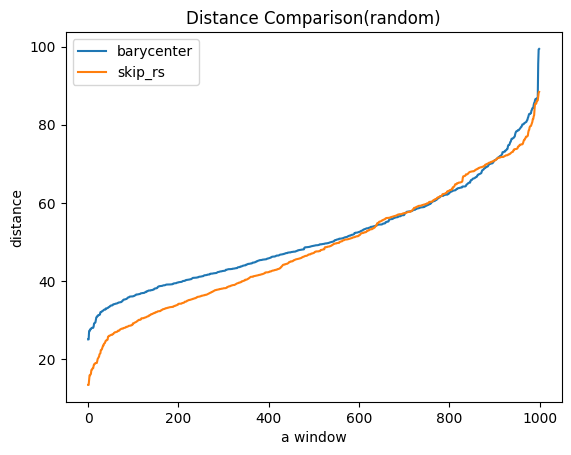

t-statistic: 4.346284554545824
p-value: 1.4541482681180742e-05
There is a significant difference between the groups.


In [32]:
z_bc_random_dist = random_compare(z_barycenter_df, z_skip)
z_rs_random_dist = random_compare(z_skip_rs, z_skip)
visual_comparison(z_bc_random_dist, z_rs_random_dist, label1='barycenter', label2='skip_rs', method='random' )
significance_test(z_bc_random_dist, z_rs_random_dist)

### Candidate 2

-------------barycenter------------


,Mean,Min,Max
0,70.024917,33.631569,102.76988


--------------skip_rs--------------


,Mean,Min,Max
0,57.087874,20.139492,107.288246


[33.63156896512306, 35.912010024719066, 35.912010024719066, 36.35637230603014, 36.35637230603014, 36.35637230603014, 37.355669147589495, 37.621012156835846, 38.164984660313806, 38.164984660313806, 38.967582396179196, 38.967582396179196, 39.40006939134738, 39.64756670172968, 39.792980711995845, 39.85446822142922, 39.968621007244046, 40.0952979594093, 40.0952979594093, 40.0952979594093, 40.82591028858865, 41.69764419140389, 42.30622750255093, 42.336311429010486, 42.44992129408507, 42.482504776276336, 42.54872565388082, 42.54872565388082, 42.671598838651896, 42.671598838651896, 42.68693012075345, 42.68693012075345, 42.68693012075345, 42.68693012075345, 42.873970848871, 42.9049931618456, 43.00772967332854, 43.73507219465001, 43.7703275498783, 44.43790588186425, 44.795162281237715, 44.91952511560483, 44.971360070405474, 44.971360070405474, 45.28418039700189, 45.40446012160805, 45.55627743900576, 45.61959750491078, 45.61959750491078, 45.804566184646696, 45.91053609913175, 45.91053609913175, 

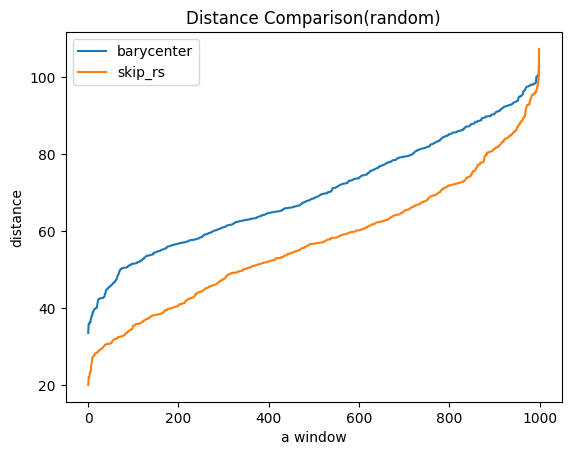

t-statistic: 18.244575966628837
p-value: 6.580929102799419e-69
There is a significant difference between the groups.


In [33]:
g_bc_random_dist = random_compare(g_barycenter_df, g_skip)
g_rs_random_dist = random_compare(g_skip_rs, g_skip)
visual_comparison(g_bc_random_dist, g_rs_random_dist, label1='barycenter', label2='skip_rs', method='random' )
significance_test(g_bc_random_dist, g_rs_random_dist)

## Top candidates accuracy

In [36]:
from Barycenter_DTW import interpolated_average

%store -r z_jump_ordered_candidates
%store -r z_walk_ordered_candidates
%store -r z_skip_ordered_candidates

### Top skip candidates compare with skip representative

In [47]:
def skip_comparison(skip_ordered_candidates, skip_series, skip_cycles): 
    correlation_arr = []
    random_dist_arr = {}
    cycles_arr = {}
    for num in range(2, len(skip_ordered_candidates), 2):
        print(str(num) + ' candidates set is running')
        bary_skip = interpolated_average(skip_ordered_candidates[: num])
        # random pick result
        dist_list = random_compare(bary_skip, skip_series)
        r_mean, r_min, r_max = np.mean(dist_list), np.min(dist_list), np.max(dist_list)
        random_dist_arr[num] = (r_mean, r_min, r_max)
        # cycles result
        c_dist_list = distances_from_cycle(skip_cycles, pd.DataFrame(bary_skip))
        c_mean, c_min, c_max = np.mean(c_dist_list), np.min(c_dist_list), np.max(c_dist_list)
        cycles_arr[num] = (c_mean, c_min, c_max)

    return random_dist_arr, cycles_arr
        

In [48]:
z_skip_random_metrics, z_skip_cycle_metrics = skip_comparison(z_skip_ordered_candidates, z_skip, z_skip_cycles)
print(z_skip_random_metrics)
print(z_skip_cycle_metrics)

2 candidates set is running
4 candidates set is running
6 candidates set is running
8 candidates set is running
10 candidates set is running
12 candidates set is running
{2: (51.46804693190633, 10.371908233396656, 98.5023094588797), 4: (49.27543812255728, 13.757538393066525, 92.90734940762678), 6: (48.151028467362785, 14.615659282012063, 93.78961645282996), 8: (47.972280349910186, 12.936033759577516, 94.83621072986682), 10: (47.739706467119525, 12.900052315255927, 88.92701111174287), 12: (49.05018823148583, 13.88905332078984, 88.38984092601524)}
{2: (38.14926601380223, 15.487552284919568, 69.82377070384857), 4: (35.09389515722313, 12.854385874363675, 65.68038579455884), 6: (32.09461335896673, 14.821019126021714, 67.3655777989932), 8: (33.19315930938307, 15.211692544466157, 66.44184221738821), 10: (32.29012161435709, 15.066860832524778, 67.07116872962739), 12: (33.152103599502986, 15.45761458928437, 65.34656594470299)}


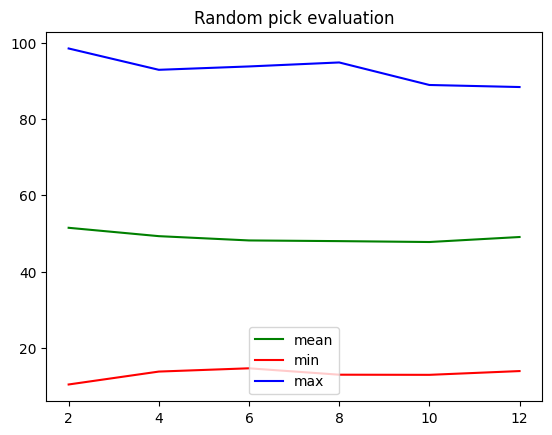

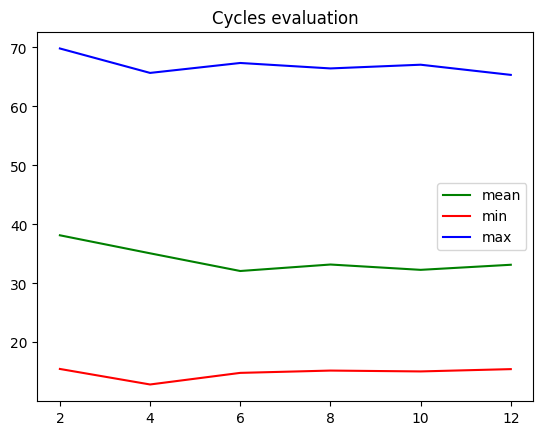

In [71]:
def plot_skip_comparison(metrics_dict, title):
    mean_arr = [tuple[0] for num, tuple in metrics_dict.items()]
    min_arr = [tuple[1] for num, tuple in metrics_dict.items()]
    max_arr = [tuple[2] for num, tuple in metrics_dict.items()]
    num_arr = metrics_dict.keys()
    plt.plot(num_arr, mean_arr, label='mean', color='green')
    plt.plot(num_arr, min_arr, label='min', color='red')
    plt.plot(num_arr, max_arr, label='max', color='blue')
    plt.title(title)
    plt.legend()
    plt.show()
        
plot_skip_comparison(z_skip_random_metrics, 'Random pick evaluation')
plot_skip_comparison(z_skip_cycle_metrics, 'Cycles evaluation')

### Top candidates barycenter accuracy

In [82]:
def bary_combine_walk_jump(jump_ordered_candidates, walk_ordered_candidates, skip_series, skip_cycles):
    # bary_walk_jump_list = []
    random_dist_arr = {}
    cycles_arr = {}
    min_can = min (len(jump_ordered_candidates), len(walk_ordered_candidates))
    for num in range(2, min_can, 2):
        print(str(num) + ' candidates set is running')
        bary_walk = interpolated_average(walk_ordered_candidates[: num])
        bary_jump = interpolated_average(jump_ordered_candidates[: num])
        bary_walk_jump = barycenter_dtw(pd.DataFrame(bary_walk), pd.DataFrame(bary_jump))
        # bary_walk_jump_list.append(bary_walk_jump.values)
    # for arr in bary_walk_jump_list:
        # random pick result
        dist_list = random_compare(bary_walk_jump, skip_series)
        r_mean, r_min, r_max = np.mean(dist_list), np.min(dist_list), np.max(dist_list)
        random_dist_arr[num] = (r_mean, r_min, r_max)
        # cycles result
        c_dist_list = distances_from_cycle(skip_cycles, pd.DataFrame(bary_walk_jump))
        c_mean, c_min, c_max = np.mean(c_dist_list), np.min(c_dist_list), np.max(c_dist_list)
        cycles_arr[num] = (c_mean, c_min, c_max)
    return random_dist_arr, cycles_arr

w_j_random_dist, w_j_cycle_dist = bary_combine_walk_jump(z_jump_ordered_candidates, z_walk_ordered_candidates, z_skip, z_skip_cycles)



2 candidates set is running
4 candidates set is running
6 candidates set is running
8 candidates set is running
10 candidates set is running
12 candidates set is running
14 candidates set is running
16 candidates set is running
18 candidates set is running
20 candidates set is running
22 candidates set is running


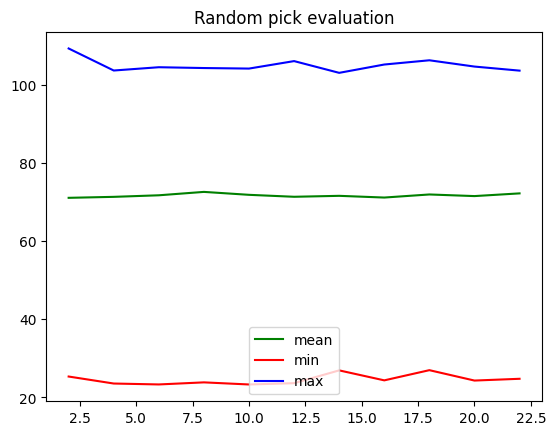

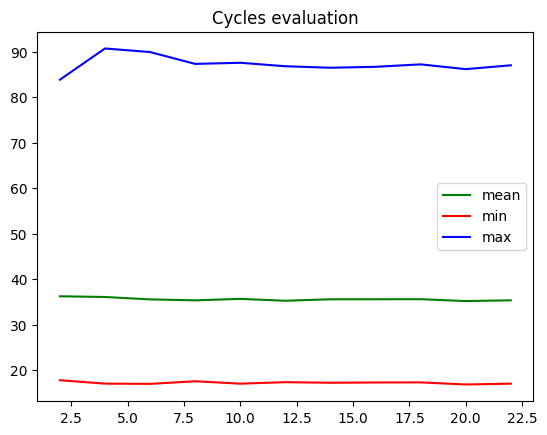

In [83]:
plot_skip_comparison(w_j_random_dist, 'Random pick evaluation')
plot_skip_comparison(w_j_cycle_dist, 'Cycles evaluation')